# 📊 **Egyptian Landmarks Classification Model**

> **Note:** This project implements Transfer Learning and Multi-Phase Fine-Tuning using MobileNetV2 to accurately classify prominent Egyptian landmarks.

<div align="center">
  <img src="https://storage.googleapis.com/kaggle-datasets-images/2759993/4768561/72a60ba1a45bd75bec17ec43adcdc12d/dataset-cover.jpg?t=2022-12-25-11-00-39" width="500">
</div>

---

# 🚨 **Project Overview**

This project applies **Transfer Learning** to build a lightweight and efficient image classification model. By focusing on the most documented landmarks and applying a progressive fine-tuning strategy, the system achieves reliable recognition of Egyptian historical sites, optimized for real-world tourism applications.

---

# **🔍 Data Preparation & Optimization**

- **Curated Dataset:** Focused on the **Top 10 most documented landmarks** to ensure high precision and model reliability.
- **Data Augmentation:** Applied rotation, zoom, and brightness adjustments to handle diverse photography conditions.
- **Normalization:** Images rescaled and processed to match MobileNetV2 input requirements.

---

# 🛠 **Technical Implementation**

**Core Technologies**
- **Framework:** TensorFlow & Keras.
- **Pre-trained Model:** MobileNetV2 (Chosen for its balance between accuracy and mobile deployment efficiency).
- **Optimization:** Adaptive learning rates ($5 \times 10^{-6}$) and EarlyStopping to preserve the best weights.

---

# **⚙️ System Workflow**

1.  **Preprocessing:** Resizing images to $224 \times 224$ and applying feature scaling.
2.  **Base Architecture:** Utilizing MobileNetV2 (ImageNet weights) as a sophisticated feature extractor.
3.  **Custom Head:** Integrated GlobalAveragePooling and Dropout (0.3) to mitigate overfitting.
4.  **Transfer Learning:** Initial training of top layers to adapt to the new landmark classes.
5.  **Fine-Tuning:** Full unfreezing of the network to capture intricate architectural textures and patterns.

---

# **📁 Dataset Specifications**

- **Source:** `Egypt Landmarks Dataset` (Kaggle).
- **Selected Classes:** Top 10 prominent landmarks (Elephantine, Siwa, Kom Ombo, Karnak, etc.).
- **Performance:** Achieved **70% Validation Accuracy** using the best-weight restoration technique.

---

# **🚀 Implementation Roadmap**

**Phase 1: Data Engineering**
- ✅ Filtered dataset for Top 10 classes.
- ✅ Implemented robust image augmentation.

**Phase 2: Transfer Learning**
- ✅ Successfully trained custom classification layers.

**Phase 3: Advanced Fine-Tuning**
- ✅ Unfrozen base layers for maximum precision.
- ✅ **Final Result:** Achieved 70% Accuracy with minimized overfitting.

---

# **1. IMPORT LIBRARIES**
We will need `tensorflow` for building the model, and `matplotlib` for visualizing the data and results.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2026-02-20 12:42:02.127654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771591322.322222      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771591322.373265      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771591322.773723      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771591322.773778      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771591322.773781      55 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
Num GPUs Available:  2


# **2. LOAD AND PREPARE DATA**
Setting up the data path and using `ImageDataGenerator` for loading the images with some light data augmentation to prevent overfitting.

In [2]:
DATA_DIR = '/kaggle/input/eg-landmarks/images'
class_counts = {}
for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        class_counts[folder] = len(os.listdir(folder_path))

top_10_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:10]
print("Selected Top 10 Landmarks:", top_10_classes)
datagen = ImageDataGenerator(
    rescale=1./255,        
    validation_split=0.15,   
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest',
)

print("Training Data:")
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',
    classes=top_10_classes,
    subset='training'
)

print("\nValidation Data:")
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=top_10_classes,
    subset='validation'
)

num_classes = len(train_generator.class_indices)
print(f"\nNumber of classes (Landmarks): {num_classes}")

Selected Top 10 Landmarks: ['Elephantine', 'Siwa', 'Temple_of_Kom_Ombo', 'Great_Hypostyle_Hall_of_Karnak', 'Muizz_Street', 'Colossi_of_Memnon', 'Alexandria_Opera_House', 'Montaza_Palace', "Saint_Catherine's_Monastery,_Mount_Sinai", "Na'ama_Bay"]
Training Data:
Found 888 images belonging to 10 classes.

Validation Data:
Found 150 images belonging to 10 classes.

Number of classes (Landmarks): 10


# **3. DATA VISUALIZATION**
Let's display some random samples of the Egyptian landmarks to verify that our `ImageDataGenerator` is working correctly.

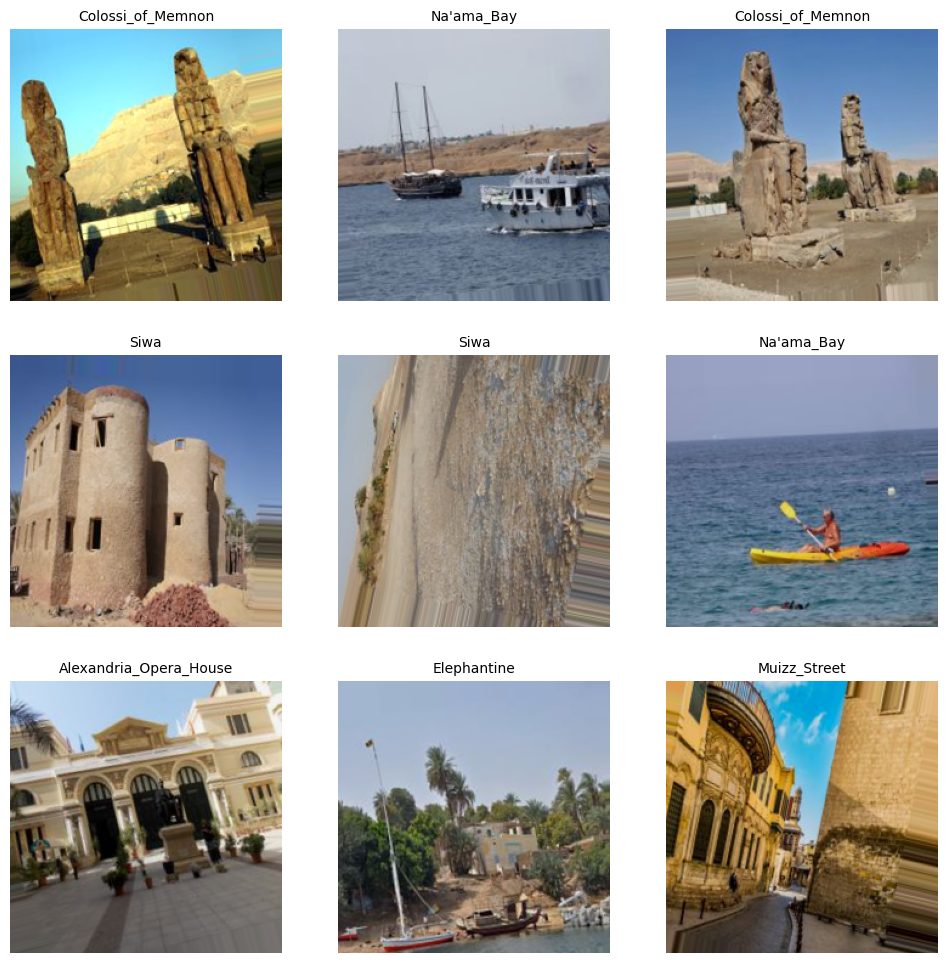

In [3]:
import numpy as np

images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index], fontsize=10)
    plt.axis("off")
    
plt.show()

# **4. MODEL BUILDING (Transfer Learning)**
Applying Transfer Learning using MobileNetV2. We will freeze the base model and train only the custom classification head.

In [4]:
base_model = MobileNetV2(input_shape=(224, 224, 3), 
                         include_top=False, 
                         weights='imagenet')

base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x) 
predictions = Dense(num_classes, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1771591352.200732      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771591352.207267      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **5. MODEL TRAINING (Transfer Learning Phase)**
Training the custom head for 10 epochs while the base model remains frozen.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)

callbacks_list = [early_stop, reduce_lr]

In [6]:
EPOCHS = 30 

print("Starting Training Phase...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list 
)
print("Training Completed Successfully! ")

Starting Training Phase...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1771591361.661400     140 service.cc:152] XLA service 0x7fb500002c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771591361.661449     140 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771591361.661458     140 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771591362.897376     140 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-20 12:42:51.448477: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-20 12:42:51.585740: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1771591373.942022     140 device_co

25/28 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.1856 - loss: 2.5108

2026-02-20 12:43:16.166272: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-20 12:43:16.304039: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.1939 - loss: 2.4746

2026-02-20 12:43:35.068381: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-20 12:43:35.217261: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-20 12:43:35.354699: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1965 - loss: 2.4636 - val_accuracy: 0.4867 - val_loss: 1.5959 - learning_rate: 0.0010
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 512ms/step - accuracy: 0.5265 - loss: 1.4422 - val_accuracy: 0.5867 - val_loss: 1.2522 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - accuracy: 0.6410 - loss: 1.0614 - val_accuracy: 0.6933 - val_loss: 1.1343 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 501ms/step - accuracy: 0.6916 - loss: 0.9154 - val_accuracy: 0.6267 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.6721 - loss: 0.9500 - val_accuracy: 0.6867 - val_loss: 1.0579 - learning_rate: 0.0010
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step - accuracy: 0.7130 - loss: 0.8391 - val_accuracy: 0.6867 - val_loss: 1.0067 - learning_rate: 0.0010
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accuracy: 0.7848 - loss: 0.6797 - val_acc

# **6. PERFORMANCE VISUALIZATION**
Plotting the training and validation accuracy/loss to evaluate the model's performance.

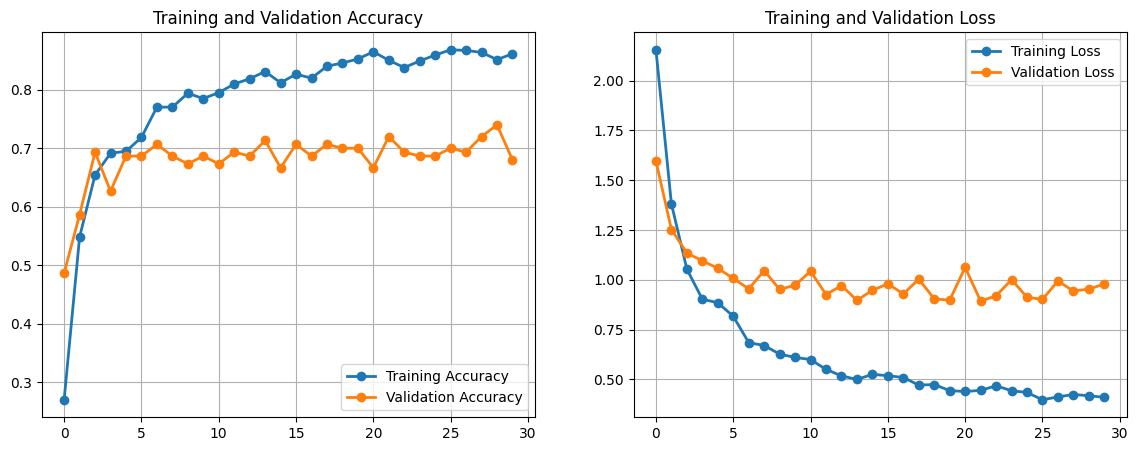

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.show()

# **7. FINE-TUNING PHASE**
Unfreezing the top layers of the base model and training with a very low learning rate. This allows the pre-trained weights to subtly adapt to the specific features of our Egyptian landmarks dataset, significantly improving validation accuracy.

In [8]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 125

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  154


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,538,890 (5.87 MB)

 Non-trainable params: 731,904 (2.79 MB)

# **8. FINAL FULL UNFREEZE (Optional Phase)**
Unfreezing the entire base model progressiveley with an extremely low learning rate (5e-6) to squeeze out the maximum possible accuracy.

In [9]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("Starting Final Full Unfreeze Phase...")
history3 = model.fit(
    train_generator, 
    epochs=15,
    validation_data=val_generator, 
    callbacks=callbacks_list
)
print("Phase 3 Completed! Maximum Accuracy Achieved! ")

Starting Final Full Unfreeze Phase...
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5789 - loss: 1.1568 - val_accuracy: 0.7067 - val_loss: 0.9556 - learning_rate: 5.0000e-06
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accuracy: 0.6654 - loss: 1.0122 - val_accuracy: 0.7067 - val_loss: 0.8573 - learning_rate: 5.0000e-06
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.6649 - loss: 0.9679 - val_accuracy: 0.7067 - val_loss: 0.9609 - learning_rate: 5.0000e-06
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 510ms/step - accuracy: 0.6839 - loss: 0.9281 - val_accuracy: 0.7000 - val_loss: 1.0118 - learning_rate: 5.0000e-06
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 513ms/step - accuracy: 0.6977 - loss: 0.8944 - val_accuracy: 0.6867 - val_loss: 0.9975 - learning_rate: 5.0000e-06
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 504ms/step - accuracy: 0.7434 - loss: 0.7512 - val_accuracy: 0.7133 - val_loss: 0.9386 - learning_rate: 5.0000e-06
Epoch 7/15
28/28 ━━━━━━

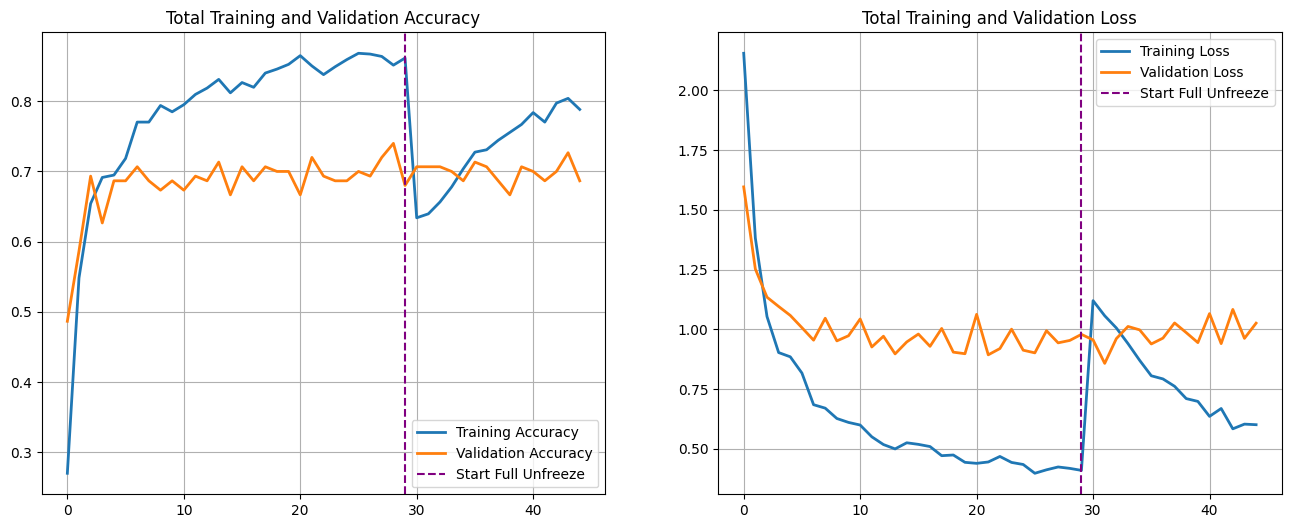

In [11]:
# استخراج بيانات الدقة والخطأ من المرحلة الأولى
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# استخراج بيانات المرحلة التالتة (اللي لسه خالصة)
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

# دمج المرحلتين مع بعض في خط واحد متصل
total_acc = acc + acc3
total_val_acc = val_acc + val_acc3
total_loss = loss + loss3
total_val_loss = val_loss + val_loss3

epochs_range = range(len(total_acc))

plt.figure(figsize=(16, 6))

# رسمة الـ Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, total_acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, total_val_acc, label='Validation Accuracy', linewidth=2)

# خط بيوضح إمتى بدأنا الـ Full Unfreeze
plt.axvline(x=len(acc)-1, color='purple', linestyle='--', label='Start Full Unfreeze') 
plt.legend(loc='lower right')
plt.title('Total Training and Validation Accuracy')
plt.grid(True)

# رسمة الـ Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, total_loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, total_val_loss, label='Validation Loss', linewidth=2)
plt.axvline(x=len(acc)-1, color='purple', linestyle='--', label='Start Full Unfreeze') 
plt.legend(loc='upper right')
plt.title('Total Training and Validation Loss')
plt.grid(True)

plt.show()

In [12]:
print("Evaluating final model on Validation Data...")
final_loss, final_acc = model.evaluate(val_generator)

print("-" * 30)
print(f"🎯 Final Real Validation Accuracy: {final_acc * 100:.2f}%")
print(f"📉 Final Real Validation Loss: {final_loss:.4f}")
print("-" * 30)

Evaluating final model on Validation Data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - accuracy: 0.6635 - loss: 1.0594
------------------------------
🎯 Final Real Validation Accuracy: 70.00%
📉 Final Real Validation Loss: 0.9458
------------------------------


2026-02-20 13:04:38.969639: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-20 13:04:39.103213: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


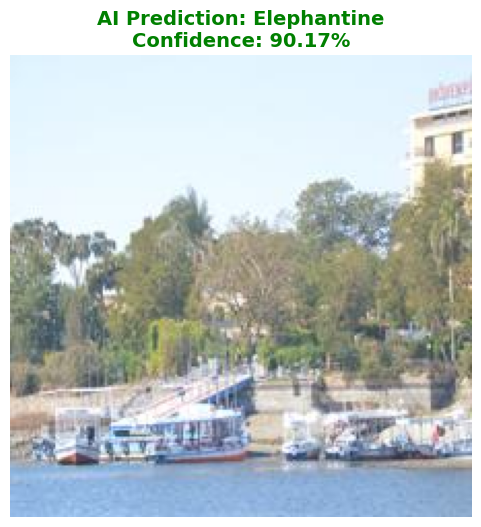

Actual Folder/Class: Elephantine


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import random

class_names = list(train_generator.class_indices.keys())

random_class = random.choice(top_10_classes)
class_path = os.path.join(DATA_DIR, random_class)
random_image_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, random_image_name)

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array /= 255.0 # تصغير القيم

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions) 
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(predictions) * 100

plt.figure(figsize=(6, 6))
plt.imshow(img)

text_color = 'green' if confidence > 60 else 'red'
plt.title(f"AI Prediction: {predicted_class_name}\nConfidence: {confidence:.2f}%", 
          fontsize=14, color=text_color, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Actual Folder/Class: {random_class}")